In [1]:
from pyspark.sql import functions as F
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
from scipy import stats

In [2]:
monthly_merchant_detail = pd.read_parquet('../data/curated/monthly_merchant_detail.parquet').sort_values(['merchant_abn', 'month'])
merchant_detail = pd.read_parquet('../data/curated/merchant_detail.parquet')

In [3]:
#remove the data for 2021-02 since there is only one day recorded.

monthly_merchant_detail = monthly_merchant_detail[monthly_merchant_detail['month']!='2021-02']

In [4]:
#compute the profit by income*take rate

monthly_merchant_detail = monthly_merchant_detail.merge(merchant_detail, on = 'merchant_abn', how = 'inner')
monthly_merchant_detail['profit'] = monthly_merchant_detail['monthly_value'] * monthly_merchant_detail['take_rate']/100
monthly_merchant_detail = monthly_merchant_detail[['month','merchant_abn','profit']]

In [9]:
#if there is not any transaction on a day for a merchant, set the profit to 0. 

dates = monthly_merchant_detail[monthly_merchant_detail['merchant_abn']==10023283211]['month']
merchants = merchant_detail['merchant_abn']
for month in dates:
    for merchant in merchants:
        if len(monthly_merchant_detail[(monthly_merchant_detail['month'] == month)& (monthly_merchant_detail['merchant_abn'] == merchant)]) == 0:
            monthly_merchant_detail.loc[len( monthly_merchant_detail.index)] = [month, merchant, 0]

In [10]:
monthly_merchant_detail = monthly_merchant_detail.sort_values(['merchant_abn', 'month'])

In [11]:
monthly_merchant_detail

,month,merchant_abn,profit
0,2021-03,10023283211,44.341822
1,2021-04,10023283211,49.720217
2,2021-05,10023283211,54.201390
3,2021-06,10023283211,51.822782
4,2021-07,10023283211,52.975317
...,...,...,...
67327,2022-04,99990536339,2.471421
67328,2022-05,99990536339,1.287060
71946,2022-06,99990536339,0.000000
67329,2022-07,99990536339,1.696435


Treat the month as independent varaibles, the profit as responses, we obtain the monthly profit growth by calculate the gradient of the line of best fit.

In [12]:
def calc_monthly_growth(df):
    """Accept a merchant dataframe with monthly profit and months, calculate the profit growth by month.
    """
    
    x = df['month']
    y = df['profit'].astype(float)

    # Create a sequance of integers from 0 to x.size to use in np.polyfit() call
    x_seq = np.arange(x.size) # should give [ 0  1  2  3  4 ... 18]

    # call numpy polyfit() method with x_seq, y 
    fit = np.polyfit(x_seq, y, 1)
    fit_fn = np.poly1d(fit)
    return fit[0]

In [13]:
profit_growth = {}
for merchant in merchants:
    profit_growth[merchant] = calc_monthly_growth(monthly_merchant_detail[monthly_merchant_detail['merchant_abn']==merchant])

In [14]:
profit_growth_df = pd.DataFrame(profit_growth.items(), columns=['merchant_abn', 'monthly_profit_growth'])
profit_growth_df.sort_values('monthly_profit_growth')

,merchant_abn,monthly_profit_growth
786,23812847062,-80.990572
563,61910841091,-80.933207
106,15043504837,-79.137158
1185,21986309398,-73.541845
1536,53877856360,-62.877455
...,...,...
4,38700038932,407.926070
25,27326652377,412.979388
1,48534649627,423.618912
6,96680767841,423.939210


/tmp/ipykernel_89/673527635.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['month_index'] = np.arange(18)+1
/home/jiaming/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


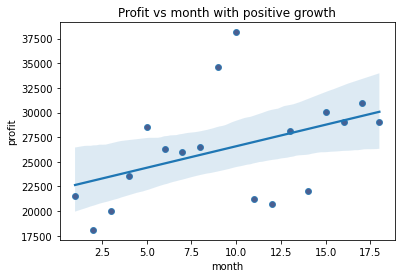

In [15]:
import seaborn as sns
sample_df = monthly_merchant_detail[monthly_merchant_detail['merchant_abn'] == 82368304209]
sample_df['month_index'] = np.arange(18)+1
sample_df.plot.scatter(x = 'month_index', y = 'profit',  c = 'red')
sns.regplot(sample_df['month_index'],sample_df['profit'])
plt.xlabel('month')
plt.title('Profit vs month with positive growth')
plt.savefig('../plots/Profit vs month with positive growth')

/tmp/ipykernel_89/4157697614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['month_index'] = np.arange(18)+1
/home/jiaming/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


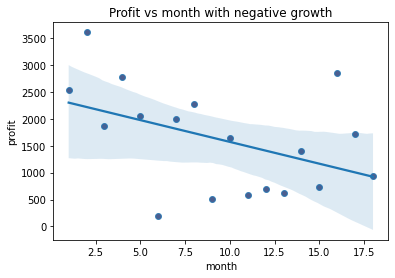

In [16]:
sample_df = monthly_merchant_detail[monthly_merchant_detail['merchant_abn'] == 23812847062]
sample_df['month_index'] = np.arange(18)+1
sample_df.plot.scatter(x = 'month_index', y = 'profit',  c = 'red')
sns.regplot(sample_df['month_index'],sample_df['profit'])
plt.xlabel('month')
plt.title('Profit vs month with negative growth')
plt.savefig('../plots/Profit vs month with negative growth')

In [17]:
merchant_detail_with_growth = merchant_detail.merge(profit_growth_df, on = 'merchant_abn', how = 'inner')

In [18]:
merchant_detail_with_growth

,merchant_abn,merchant_name,type,take_rate,total_income,total_transactions,mean_transaction_amount,BNPL_monthly_profit,monthly_profit_growth
0,79827781481,Amet Risus Inc.,"furniture, home furnishings and equipment shop...",6.82,8657277.10,4251,2037.0,32801.0,259.730041
1,48534649627,Dignissim Maecenas Foundation,"opticians, optical goods, and eyeglasses",6.64,8316735.67,58685,142.0,30680.0,423.618912
2,32361057556,Orci In Consequat Corporation,"gift, card, novelty, and souvenir shops",6.61,8339994.52,75853,110.0,30626.0,373.577904
3,86578477987,Leo In Consulting,"watch, clock, and jewelry repair shops",6.43,8443178.70,241336,35.0,30161.0,386.294528
4,38700038932,Etiam Bibendum Industries,tent and awning shops,6.31,8482176.66,6341,1338.0,29735.0,407.926070
...,...,...,...,...,...,...,...,...,...
4021,46391946761,Libero Nec Ligula LLP,"stationery, office supplies and printing and w...",0.37,13442.35,15,896.0,3.0,-0.209182
4022,64196096120,Turpis Incorporated,"gift, card, novelty, and souvenir shops",0.23,16159.06,156,104.0,2.0,0.040707
4023,25019506172,Proin Vel Inc.,"stationery, office supplies and printing and w...",0.16,21967.78,31,709.0,2.0,0.166143
4024,57079678065,Hendrerit Donec Limited,"digital goods: books, movies, music",0.18,20034.94,590,34.0,2.0,0.032130


In [19]:
merchant_detail_with_growth.to_csv('../data/curated/merchant_detail_with_monthly_growth.csv', index = False)